# Current Source Density Analysis

### Environment Setup

In [34]:
import numpy as np

from dandi import dandiapi
from elephant.current_source_density import generate_lfp, estimate_csd
from elephant.current_source_density_src.utility_functions import gauss_1d_dipole, small_source_2D
from neo import AnalogSignal
from pynwb import NWBHDF5IO
import quantities as pq
import matplotlib.pyplot as plt

### Downloading Ecephys File
If you don't already have files to analyze, you can use data from The Allen Institute's **Visual Coding - Neuropixels** dataset. If you want to choose your own files to download, set `dandiset_id`, `dandi_stim_filepath`, `dandi_lfp_filepath` accordingly.

In [2]:
dandiset_id = "000336"
dandi_filepath = "sub_1171903433/sub_1171903433sess_1181330601/sub_1171903433+sess_1181330601+probeA_ecephys.nwb"

authenticate = False
dandi_api_key = ""

In [19]:
if authenticate:
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
else:
    client = dandiapi.DandiAPIClient()
my_dandiset = client.get_dandiset(dandiset_id)

filename = dandi_filepath.split("/")[-1]
filepath = f"./{filename}"
file = my_dandiset.get_asset_by_path(dandi_filepath)

A newer version (0.51.0) of dandi/dandi-cli is available. You are using 0.46.3
Error 401 while sending GET request to https://api.dandiarchive.org/api/dandisets/000336/: {"detail":"Authentication credentials were not provided."}


HTTPError: Error 401 while sending GET request to https://api.dandiarchive.org/api/dandisets/000336/: {"detail":"Authentication credentials were not provided."}

In [3]:
# # this may take awhile, especially if the file to download is large
# file.download(filepath)

# print(f"Downloaded file to {filepath}")

In [4]:
io = NWBHDF5IO("../../../data/illusion/sub_1171903433+sess_1181330601+probeA_ecephys.nwb", mode="r", load_namespaces=True)
nwb = io.read()

C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Extracting Data

In [5]:
lfp = nwb.acquisition["probe_0_lfp_data"]
lfp

probe_0_lfp_data pynwb.ecephys.ElectricalSeries at 0x2209800702608
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (11252278, 89), type "<f4">
  description: no description
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (11252278,), type "<f8">
  timestamps_unit: seconds
  unit: volts

In [90]:
coords = np.array([(elem,) for elem in np.linspace(0,89,89)])

### Selecting a Period
Oftentimes, the LFP data can be very large. Depending on the machine this analysis is performed on, there may not be enough memory to perform the current source density estimation. So it can be performed on some smaller period of time within the LFP data. If you wish to do this, set `period_start` and `period_end` to be reasonable times (in seconds) within the experiment to look at. Below are printed the first and last timestamps from the stimulus data and LFP data to inform this choice.

In [91]:
print(lfp.timestamps[0])
print(lfp.timestamps[-1])

4.787164854572537
9006.599064801605


In [92]:
# period_start = lfp.timestamps[0]
period_start = 5000
# period_end = lfp.timestamps[-1]
period_end = 5001

In [93]:
# find indices within lfp data that correspond to period bounds
period_start_idx, period_end_idx = None, None
for i, ts in enumerate(lfp.timestamps):
    if not period_start_idx and ts >= period_start:
        period_start_idx = i
    if period_start_idx and ts >= period_end:
        period_end_idx = i
        break

if period_start_idx == None or period_end_idx == None:
    raise ValueError("Period bounds not found within lfp data")

# get slice of LFP data corresponding to the period bounds
lfp_timestamps = lfp.timestamps[period_start_idx:period_end_idx]
lfp_data = lfp.data[period_start_idx:period_end_idx]

In [108]:
print(lfp_timestamps.shape)
print(lfp_data.shape)

(1250,)
(1250, 89)


### Using Elephant to calculate CSD

In [113]:
hz = len(lfp_data) / (lfp_timestamps[-1] - lfp_timestamps[0])
coords = [(elem,) for elem in range(lfp_data.shape[1])]

neo_lfp = AnalogSignal(lfp_data, units="V", sampling_rate = hz*pq.Hz)
neo_lfp.annotate(coordinates = coords * pq.mm)

In [114]:
csd = estimate_csd(neo_lfp, method="KCSD1D")

No lambda given, using defaults
Cross validating R (all lambda) : 0.23
R, lambda : 0.23 0.00012115276586285876


### Displaying Current Source Density

Text(0, 0.5, 'Distance along probe (%)')

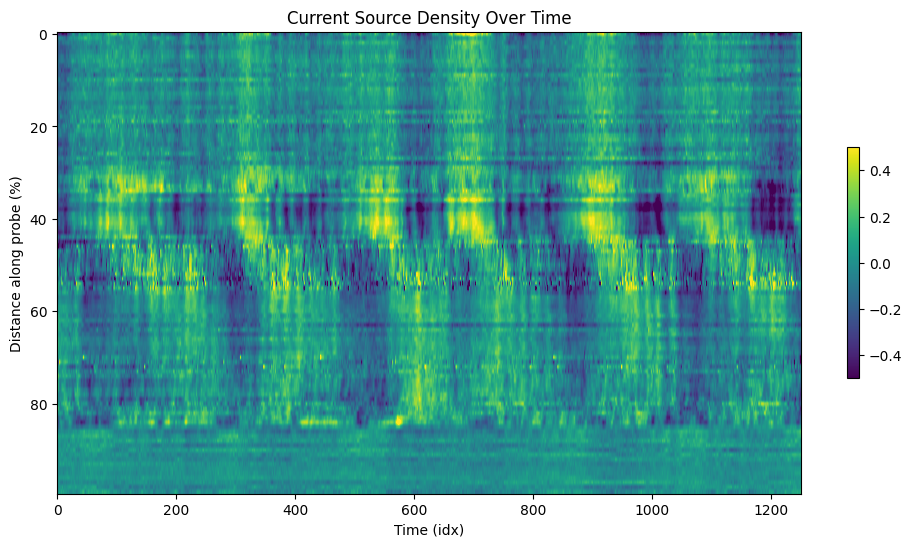

In [117]:
fig, ax = plt.subplots(figsize=(12,6))
img = ax.imshow(csd_a.transpose(), aspect="auto", vmin=-0.5, vmax=0.5)
cbar = fig.colorbar(img, shrink=0.5)
cbar.set_label("")

ax.set_title("Current Source Density Over Time")
ax.set_xlabel("Time (idx)")
ax.set_ylabel("Distance along probe (%)")